Shivali Chandra <br>
1/30/16 <br>
Warmup Project Iteration 2

Inspiration 1: http://elenacuoco.altervista.org/blog/archives/1195?doing_wp_cron=1454278621.7234199047088623046875, provides a great overview of how the author figured out which values would be relevant <br>
Inspiration 2: https://triangleinequality.wordpress.com/2013/09/05/a-complete-guide-to-getting-0-79903-in-kaggles-titanic-competition-with-python/, good overview as to how to structure the code and model as decision trees. This was a really interesting approach, because it basically weighted different factors as deciding factors or questions leading to more factors (for example, starting with a male, checking the passenger class and moving to different factors based on the result). I did not implement this entirely, but read through it and the links it pointed to in order to get a better sense of how to modify my model. 

In [51]:
%matplotlib inline
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cross_validation import KFold
from sklearn import cross_validation
import numpy as np
import matplotlib.pyplot as plt 
import thinkplot
import thinkstats2
import string

I incorporated my own ideas by going through and seeing how the ideas in the two articles could be combined, especially with respect to different variables. Some of the variables I used were different, because I am interested in seeing the difference that they make, not necessarily just in achieving a higher score each time. 

In [60]:
train = pd.read_csv('train.csv')

train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The biggest impact that this blog had on my model was the fact that it parsed for title and used that to assign age, rather than using the same mean. This actually seems pretty significant because there are over 200 ages missing, and with about 900 total people that is a large portion, so trying to get the age in a closer range is important. 

In [61]:
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if string.find(big_string, substring) != -1:
            return substring
    print big_string
    return np.nan

title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                'Don', 'Jonkheer']
train['Title']=train['Name'].map(lambda x: substrings_in_string(x, title_list))

#replacing all titles with mr, mrs, miss, master
def replace_titles(x):
    title=x['Title']
    if title in ['Mr','Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Master']:
        return 'Master'
    elif title in ['Countess', 'Mme','Mrs']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms','Miss']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    elif title =='':
        if x['Sex']=='Male':
            return 'Master'
        else:
            return 'Miss'
    else:
        return title

train['Title']=train.apply(replace_titles, axis=1)

train['AgeFill']=train['Age']
mean_ages = np.zeros(4)
mean_ages[0]=np.average(train[train['Title'] == 'Miss']['Age'].dropna())
mean_ages[1]=np.average(train[train['Title'] == 'Mrs']['Age'].dropna())
mean_ages[2]=np.average(train[train['Title'] == 'Mr']['Age'].dropna())
mean_ages[3]=np.average(train[train['Title'] == 'Master']['Age'].dropna())
train.loc[ (train.Age.isnull()) & (train.Title == 'Miss') ,'AgeFill'] = mean_ages[0]
train.loc[ (train.Age.isnull()) & (train.Title == 'Mrs') ,'AgeFill'] = mean_ages[1]
train.loc[ (train.Age.isnull()) & (train.Title == 'Mr') ,'AgeFill'] = mean_ages[2]
train.loc[ (train.Age.isnull()) & (train.Title == 'Master') ,'AgeFill'] = mean_ages[3]

In [63]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,AgeFill
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,29.819131
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,13.285423
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.420000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,21.835616
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,30.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,35.841667
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,80.000000


Now that we have cleaner data, of the first suggestions of the first blog was to make plots of age and other characteristics to see if there was any correlation: 

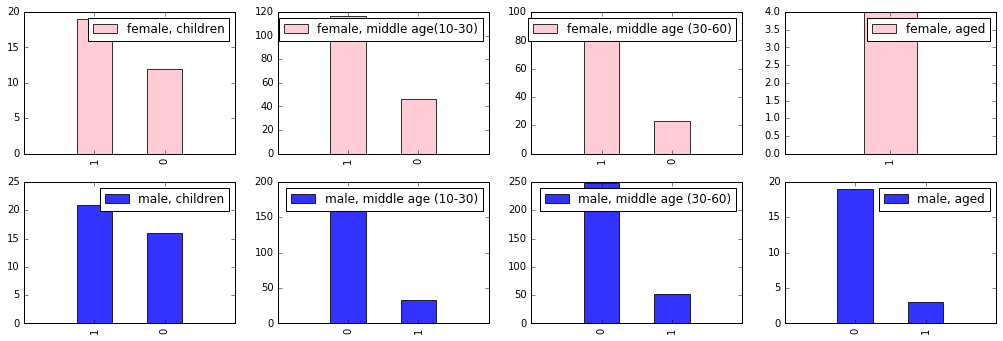

In [62]:
fig = plt.figure(figsize=(20,6), dpi=1600 )
a=0.8 
 
plt.subplots_adjust(bottom=0.1, right=0.8, top=2)    

##gender and age
#female
ax7 = fig.add_subplot(5,4,12)
female_aged = train.Survived[train.Sex == 'female'][train.AgeFill >= 60].value_counts()
female_aged.plot(kind='bar', label='female, aged', color='pink', alpha=a)
 
ax7.set_xlim(-1, len(female_aged))
plt.legend(loc='best')
ax8 = fig.add_subplot(5,4,9)
female_child = train.Survived[train.Sex == 'female'][train.AgeFill <= 10].value_counts()
female_child.plot(kind='bar', label='female, children', color='pink', alpha=a)
 
ax8.set_xlim(-1, len(female_child))
plt.legend(loc='best')
ax9 = fig.add_subplot(5,4,10)
female_middleage = train.Survived[train.Sex == 'female'][train.AgeFill>10][train.AgeFill<=30].value_counts()
female_middleage.plot(kind='bar', label='female, middle age(10-30)', color='pink', alpha=a)
 
ax9.set_xlim(-1, len(female_middleage))
plt.legend(loc='best')
ax9 = fig.add_subplot(5,4,11)
female_middleage = train.Survived[train.Sex == 'female'][train.AgeFill>30][train.AgeFill<60].value_counts()
female_middleage.plot(kind='bar', label='female, middle age (30-60)', color='pink', alpha=a)
 
ax9.set_xlim(-1, len(female_middleage))
plt.legend(loc='best')
 
#male
 
ax10 = fig.add_subplot(5,4,16)
male_aged = train.Survived[train.Sex == 'male'][train.AgeFill >= 60].value_counts()
male_aged.plot(kind='bar', label='male, aged', color='blue', alpha=a)
 
ax10.set_xlim(-1, len(male_aged))
plt.legend(loc='best')
ax11 = fig.add_subplot(5,4,13)
male_child = train.Survived[train.Sex == 'male'][train.AgeFill <= 10].value_counts()
male_child.plot(kind='bar', label='male, children', color='blue', alpha=a)
 
ax11.set_xlim(-1, len(male_child))
plt.legend(loc='best')
ax12 = fig.add_subplot(5,4,14)
male_middleage = train.Survived[train.Sex == 'male'][train.AgeFill>10][train.AgeFill<=30].value_counts()
male_middleage.plot(kind='bar', label='male, middle age (10-30)', color='blue', alpha=a)
 
ax12.set_xlim(-1, len(male_middleage))
plt.legend(loc='best') 
ax12 = fig.add_subplot(5,4,15)
male_middleage = train.Survived[train.Sex == 'male'][train.AgeFill>30][train.AgeFill<60].value_counts()
male_middleage.plot(kind='bar', label='male, middle age (30-60)', color='blue', alpha=a)
 
ax12.set_xlim(-1, len(male_middleage))
plt.legend(loc='best')
plt.show()

From this we gain some very interesting and potentially useful information: 
- the four aged females all survived
- female children had slightly under 2/3 chance of survival, not as high as I would have suspected. On the other hand, females between 10-30 had around a 3/4 chance, while females between 30-60 had about a 4/5 chance of survival
- male children had the best chance of surviving, with men between 30-60 next (about a 1/5 chance)

Next, checking once again the passenger class and gender correlation: 

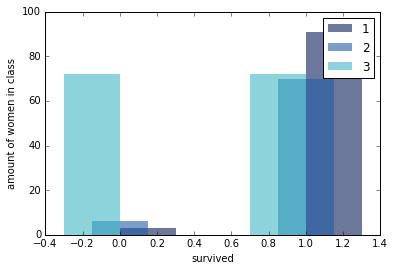

In [58]:
female = train[train.Sex == 'female']
hist = thinkstats2.Hist(female[train.Pclass == 1].Survived)
hist1 = thinkstats2.Hist(female[train.Pclass == 2].Survived)
hist2 = thinkstats2.Hist(female[train.Pclass == 3].Survived)
thinkplot.PrePlot(3)
thinkplot.Hist(hist, align='left', width=0.3, label='1')
thinkplot.Hist(hist1, align='center', width=0.3, label='2')
thinkplot.Hist(hist2, align='right', width=0.3, label='3')
thinkplot.Show(xlabel='survived', ylabel='amount of women in class')

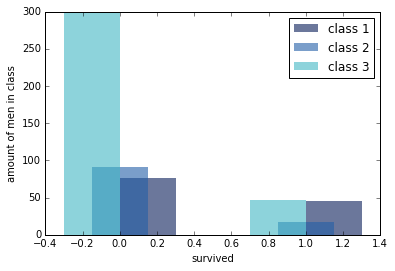

In [59]:
male = train[train.Sex == 'male']
hist = thinkstats2.Hist(male[train.Pclass == 1].Survived)
hist1 = thinkstats2.Hist(male[train.Pclass == 2].Survived)
hist2 = thinkstats2.Hist(male[train.Pclass == 3].Survived)
thinkplot.PrePlot(3)
thinkplot.Hist(hist, align='left', width=0.3, label='class 1')
thinkplot.Hist(hist1, align='center', width=0.3, label='class 2')
thinkplot.Hist(hist2, align='right', width=0.3, label='class 3')
thinkplot.Show(xlabel='survived', ylabel='amount of men in class')

For the females, it appears there is a stronger correlation between class and survival; nearly all high class and middle class females survived, while there was about a 50-50 split between the third class, which was given lower priority during the sinking. <br>
For the males there is certainly a higher ratio of high class and middle class males who survived, but it is not as significant. <br>
Because of this correlation between age, gender, and class I will try to incorporate that into my model. 